In [53]:

import os

import torch
import torch.nn as nn
import torch.nn.functional as F

latent_dims = 2
num_epochs = 10
batch_size = 64
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



In [54]:
class Encoder(nn.Module):
    def __init__(self,latent_dim : int):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.dp = nn.Dropout(p=0.2)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dp(x)
        x = F.relu(self.conv2(x))
        x = self.dp(x)
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self,latent_dim : int):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
        
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self,latent_dim : int):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(recon_x, x, mu, logvar):
   
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence
    
    
vae = VariationalAutoencoder(2)

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode


Number of parameters: 308357


In [55]:


train_loss_avg = []
print('MNIST Latent Dimension 2')
print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    vae.train()
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        # print('1',loss,'2',loss.item)
        train_loss_avg[-1] += loss.item()
        num_batches += 1
    
    # test
    vae.eval()
    test_loss = 0
    batch = 0
    with torch.no_grad():
        for data, _ in test_dataloader:
            image_batch = data.to(device)

            decode_item, mu, logvar = vae(image_batch)
            loss = vae_loss(decode_item, image_batch, mu, logvar)
            test_loss += loss.item()
            batch += 1


        
    train_loss_avg[-1] /= num_batches
    test_loss_avg = test_loss/batch
    print('Epoch [%d / %d] average training error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
    print('Epoch [%d / %d] average  testing error: %f' % (epoch+1, num_epochs, test_loss_avg))

    

MNIST Latent Dimension 2
Training ...
Epoch [1 / 10] average training error: 11461.782540
Epoch [1 / 10] average  testing error: 10617.526865
Epoch [2 / 10] average training error: 10596.220818
Epoch [2 / 10] average  testing error: 10234.594319
Epoch [3 / 10] average training error: 10386.870025
Epoch [3 / 10] average  testing error: 10124.460827
Epoch [4 / 10] average training error: 10278.143099
Epoch [4 / 10] average  testing error: 10041.673786
Epoch [5 / 10] average training error: 10205.864050
Epoch [5 / 10] average  testing error: 9982.392077
Epoch [6 / 10] average training error: 10156.775391
Epoch [6 / 10] average  testing error: 9944.828063
Epoch [7 / 10] average training error: 10120.090262
Epoch [7 / 10] average  testing error: 9936.418014
Epoch [8 / 10] average training error: 10091.395722
Epoch [8 / 10] average  testing error: 9879.559940
Epoch [9 / 10] average training error: 10068.807478
Epoch [9 / 10] average  testing error: 9857.512112
Epoch [10 / 10] average trainin

MNIST Latent Dimension 2
train orignal


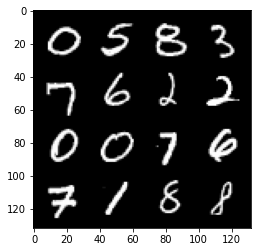

VAE train_images:


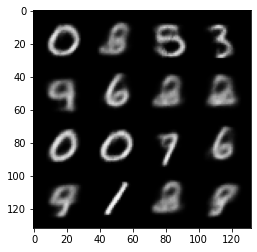

VAE test_images:


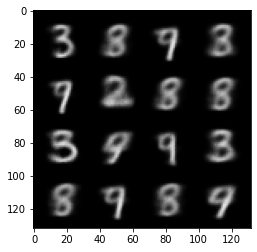

In [56]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:17], 4, 4).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()
train_images, labels = iter(train_dataloader).next()
test_images, labels = iter(test_dataloader).next()

# First visualise the original images



print('MNIST Latent Dimension 2')
print('train orignal')
show_image(torchvision.utils.make_grid(train_images[1:17], 4, 4))
plt.show()
print('VAE train_images:')
visualise_output(train_images, vae)

print('VAE test_images:')
visualise_output(test_images, vae)


MNIST Latent Dimension 2


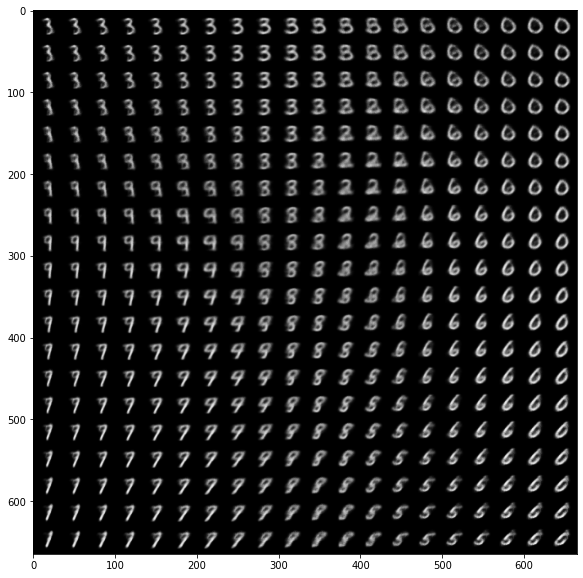

In [57]:

with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae.decoder(latents)
    image_recon = image_recon.cpu()
    print('MNIST Latent Dimension 2')
    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    plt.show()

(10000, 2)
[[ 1.77703559  0.23177534]
 [ 0.82924628 -0.27332118]
 [-0.03722953 -2.29193068]
 ...
 [-0.96751964  0.01874427]
 [-2.56573248 -0.69358772]
 [ 1.54709113 -0.44356319]]
[0. 6. 5. ... 7. 1. 0.]
MNIST Latent Dimension 2


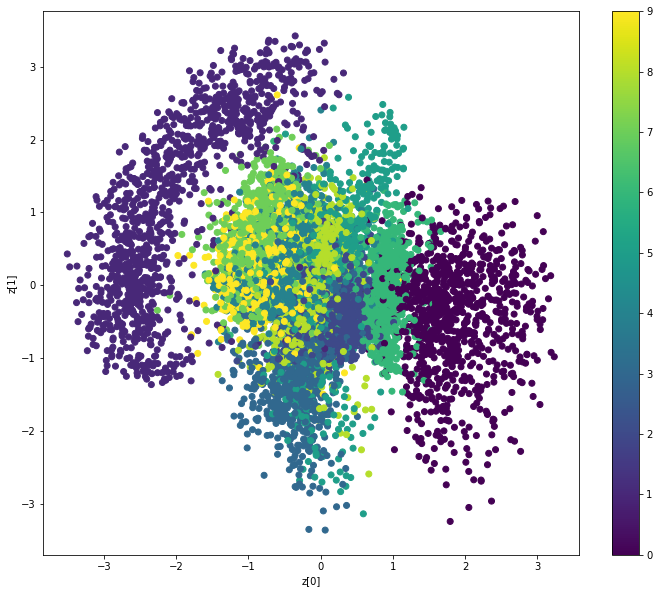

In [58]:

# display a 2D plot of the digit classes in the latent space
# decode_item, mu, logvar = vae(data)
import numpy as np
mu_total = np.array([])
labels = np.array([])
for data, label in test_dataloader:
    # print(label)
    image_batch = data.to(device)
    
    decode_item, mu, logvar = vae(image_batch)
    # print('t',mu_total,mu)
    # print(mu.cpu().detach().numpy())
    mu_total = np.append(mu_total,mu.cpu().detach().numpy())
    # print(mu_total)
    labels = np.append(labels,label.cpu().detach().numpy())
# print(mu)

mu_total = mu_total.reshape((-1,2))
print(mu_total.shape)
print(mu_total)
print(labels)
# numpy.array(labels).reshape(-1)
print('MNIST Latent Dimension 2')
plt.figure(figsize=(12, 10))
plt.scatter(mu_total[:, 0], mu_total[:, 1], c=labels)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()




In [59]:
vae32 = VariationalAutoencoder(32)


vae32 = vae32.to(device)

optimizer = torch.optim.Adam(params=vae32.parameters(), lr=learning_rate, weight_decay=1e-5)


train_loss_avg = []
print('MNIST Latent Dimension 32')
print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    vae.train()
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae32(image_batch)
        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        # print('1',loss,'2',loss.item)
        train_loss_avg[-1] += loss.item()
        num_batches += 1
    
    # test
    vae32.eval()
    test_loss = 0
    batch = 0
    with torch.no_grad():
        for data, _ in test_dataloader:
            image_batch = data.to(device)

            decode_item, mu, logvar = vae32(image_batch)
            loss = vae_loss(decode_item, image_batch, mu, logvar)
            test_loss += loss.item()
            batch += 1


        
    train_loss_avg[-1] /= num_batches
    test_loss_avg = test_loss/batch
    print('Epoch [%d / %d] average training error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
    print('Epoch [%d / %d] average  testing error: %f' % (epoch+1, num_epochs, test_loss_avg))

MNIST Latent Dimension 32
Training ...
Epoch [1 / 10] average training error: 11447.023459
Epoch [1 / 10] average  testing error: 10531.068706
Epoch [2 / 10] average training error: 10088.623868
Epoch [2 / 10] average  testing error: 9959.596754
Epoch [3 / 10] average training error: 9832.424864
Epoch [3 / 10] average  testing error: 9761.318087
Epoch [4 / 10] average training error: 9702.494951
Epoch [4 / 10] average  testing error: 9656.933836
Epoch [5 / 10] average training error: 9611.047340
Epoch [5 / 10] average  testing error: 9547.506968
Epoch [6 / 10] average training error: 9548.268912
Epoch [6 / 10] average  testing error: 9507.680426
Epoch [7 / 10] average training error: 9492.962449
Epoch [7 / 10] average  testing error: 9465.322188
Epoch [8 / 10] average training error: 9445.426769
Epoch [8 / 10] average  testing error: 9507.335917
Epoch [9 / 10] average training error: 9406.091009
Epoch [9 / 10] average  testing error: 9419.697360
Epoch [10 / 10] average training error: 

MNIST Latent Dimension 32
train orignal


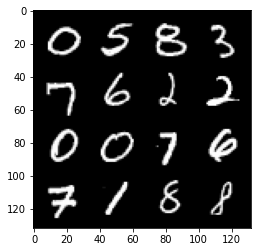

VAE train_images:


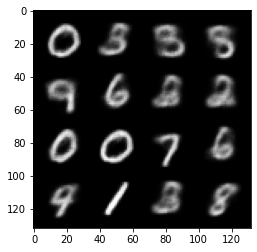

VAE test_images:


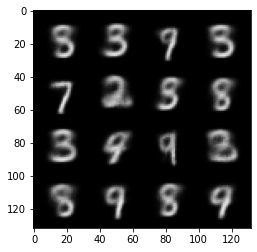

In [60]:
vae32.eval()

# First visualise the original images



print('MNIST Latent Dimension 32')
print('train orignal')
show_image(torchvision.utils.make_grid(train_images[1:17], 4, 4))
plt.show()
print('VAE train_images:')
visualise_output(train_images, vae32)

print('VAE test_images:')
visualise_output(test_images, vae32)

In [61]:
from torchvision.datasets import FashionMNIST
trainSet = FashionMNIST(root='FashionMNIST', download=True, train=True, transform=img_transform)
testSet = FashionMNIST(root='FashionMNIST', download=True, train=False, transform=img_transform)
train_dataloader = DataLoader(trainSet, batch_size=64, shuffle=True)
test_dataloader = DataLoader(testSet, batch_size=64, shuffle=False)


In [62]:
vae2 = VariationalAutoencoder(2)


vae2 = vae2.to(device)

optimizer = torch.optim.Adam(params=vae2.parameters(), lr=learning_rate, weight_decay=1e-5)


train_loss_avg = []
print('FashionMNIST Latent Dimension 2')
print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    vae.train()
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae2(image_batch)
        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        # print('1',loss,'2',loss.item)
        train_loss_avg[-1] += loss.item()
        num_batches += 1
    
    # test
    vae2.eval()
    test_loss = 0
    batch = 0
    with torch.no_grad():
        for data, _ in test_dataloader:
            image_batch = data.to(device)

            decode_item, mu, logvar = vae2(image_batch)
            loss = vae_loss(decode_item, image_batch, mu, logvar)
            test_loss += loss.item()
            batch += 1


        
    train_loss_avg[-1] /= num_batches
    test_loss_avg = test_loss/batch
    print('Epoch [%d / %d] average training error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
    print('Epoch [%d / %d] average  testing error: %f' % (epoch+1, num_epochs, test_loss_avg))

FashionMNIST Latent Dimension 2
Training ...
Epoch [1 / 10] average training error: 18059.802519
Epoch [1 / 10] average  testing error: 17373.248809
Epoch [2 / 10] average training error: 16845.740310
Epoch [2 / 10] average  testing error: 16807.233674
Epoch [3 / 10] average training error: 16681.017192
Epoch [3 / 10] average  testing error: 16635.803132
Epoch [4 / 10] average training error: 16584.017795
Epoch [4 / 10] average  testing error: 16611.632691
Epoch [5 / 10] average training error: 16512.252890
Epoch [5 / 10] average  testing error: 16586.627965
Epoch [6 / 10] average training error: 16466.117409
Epoch [6 / 10] average  testing error: 16527.465582
Epoch [7 / 10] average training error: 16424.834283
Epoch [7 / 10] average  testing error: 16473.255051
Epoch [8 / 10] average training error: 16387.044692
Epoch [8 / 10] average  testing error: 16459.439887
Epoch [9 / 10] average training error: 16358.789678
Epoch [9 / 10] average  testing error: 16467.422637
Epoch [10 / 10] ave

FashionMNIST Latent Dimension 2
tensor([2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2])
train orignal


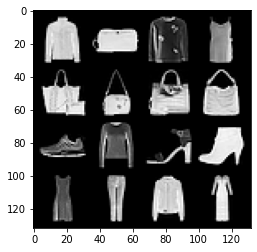

VAE train_images:


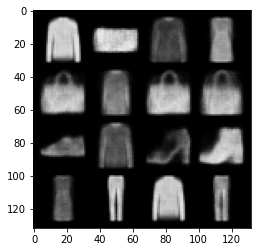

VAE test_images:


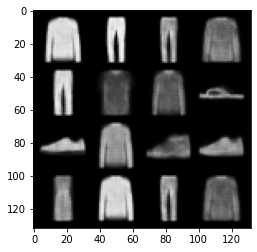

In [70]:
train_images, labels = iter(train_dataloader).next()
test_images, labels = iter(test_dataloader).next()

print('FashionMNIST Latent Dimension 2')
print(labels[1:17])
print('train orignal')
show_image(torchvision.utils.make_grid(train_images[1:17], 4, 4))
plt.show()
print('VAE train_images:')
visualise_output(train_images, vae2)

print('VAE test_images:')
visualise_output(test_images, vae2)

FashionMNIST Latent Dimension 2


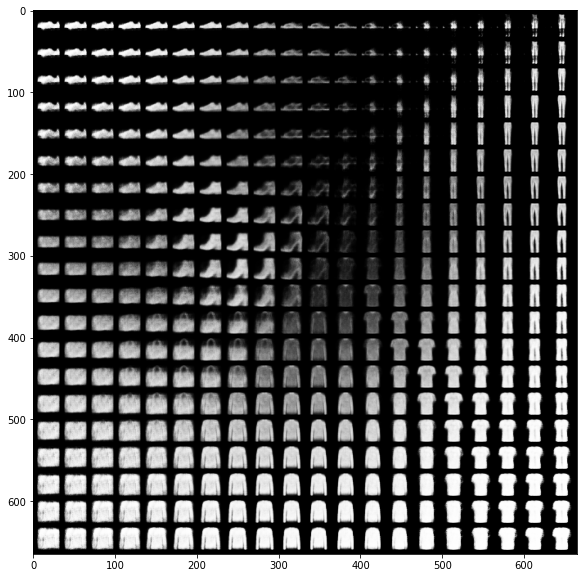

In [64]:
with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae2.decoder(latents)
    image_recon = image_recon.cpu()
    print('FashionMNIST Latent Dimension 2')
    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    plt.show()

(10000, 2)
[[ 1.77703559  0.23177534]
 [ 0.82924628 -0.27332118]
 [-0.03722953 -2.29193068]
 ...
 [-0.96751964  0.01874427]
 [-2.56573248 -0.69358772]
 [ 1.54709113 -0.44356319]]
[9 2 1 ... 4 4 0]
FashionMNIST Latent Dimension 2


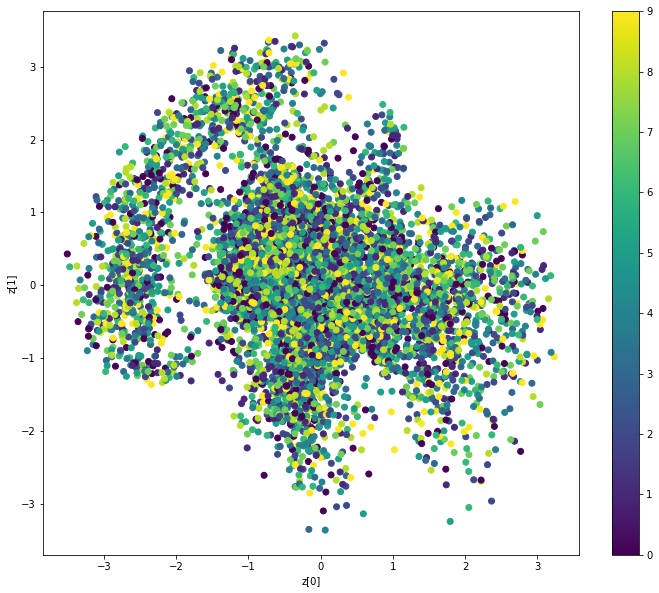

In [69]:
for data, label in train_dataloader:
    # print(label)
    image_batch = data.to(device)
    
    decode_item, mu, logvar = vae2(image_batch)
    # print('t',mu_total,mu)
    # print(mu.cpu().detach().numpy())
    mu_total = np.append(mu_total,mu.cpu().detach().numpy())
    # print(mu_total)
    labels = np.append(labels,label.cpu().detach().numpy())
# print(mu)

mu_total = mu_total.reshape((-1,2))
mu_total = mu_total[:10000]
labels = labels[:10000]
print(mu_total.shape)
print(mu_total)
print(labels)
# numpy.array(labels).reshape(-1)
print('FashionMNIST Latent Dimension 2')
plt.figure(figsize=(12, 10))
plt.scatter(mu_total[:, 0], mu_total[:, 1], c=labels)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

In [67]:
vae32 = VariationalAutoencoder(32)


vae32 = vae32.to(device)

optimizer = torch.optim.Adam(params=vae32.parameters(), lr=learning_rate, weight_decay=1e-5)


train_loss_avg = []
print('FashionMNIST Latent Dimension 32')
print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    vae.train()
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae32(image_batch)
        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        # print('1',loss,'2',loss.item)
        train_loss_avg[-1] += loss.item()
        num_batches += 1
    
    # test
    vae32.eval()
    test_loss = 0
    batch = 0
    with torch.no_grad():
        for data, _ in test_dataloader:
            image_batch = data.to(device)

            decode_item, mu, logvar = vae32(image_batch)
            loss = vae_loss(decode_item, image_batch, mu, logvar)
            test_loss += loss.item()
            batch += 1


        
    train_loss_avg[-1] /= num_batches
    test_loss_avg = test_loss/batch
    print('Epoch [%d / %d] average training error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
    print('Epoch [%d / %d] average  testing error: %f' % (epoch+1, num_epochs, test_loss_avg))

FashionMNIST Latent Dimension 32
Training ...
Epoch [1 / 10] average training error: 18414.885518
Epoch [1 / 10] average  testing error: 17347.095731
Epoch [2 / 10] average training error: 16890.025567
Epoch [2 / 10] average  testing error: 16790.542199
Epoch [3 / 10] average training error: 16709.210477
Epoch [3 / 10] average  testing error: 16655.917348
Epoch [4 / 10] average training error: 16615.203970
Epoch [4 / 10] average  testing error: 16645.595786
Epoch [5 / 10] average training error: 16553.518866
Epoch [5 / 10] average  testing error: 16616.846946
Epoch [6 / 10] average training error: 16507.834258
Epoch [6 / 10] average  testing error: 16551.871268
Epoch [7 / 10] average training error: 16461.468843
Epoch [7 / 10] average  testing error: 16538.832998
Epoch [8 / 10] average training error: 16429.861237
Epoch [8 / 10] average  testing error: 16499.974762
Epoch [9 / 10] average training error: 16399.518460
Epoch [9 / 10] average  testing error: 16469.542320
Epoch [10 / 10] av

FashionMNIST Latent Dimension 32
train orignal


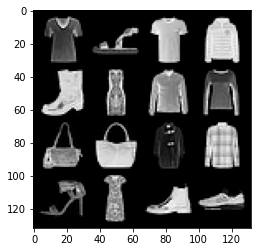

VAE train_images:


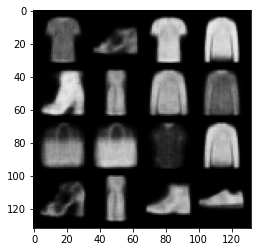

VAE test_images:


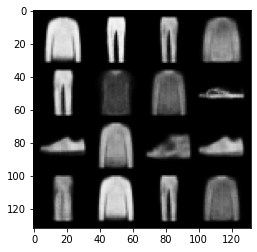

In [68]:
vae32.eval()

# First visualise the original images



print('FashionMNIST Latent Dimension 32')
print('train orignal')
show_image(torchvision.utils.make_grid(train_images[1:17], 4, 4))
plt.show()
print('VAE train_images:')
visualise_output(train_images, vae32)

print('VAE test_images:')
visualise_output(test_images, vae32)